In [ ]:
# Algorithms Used in the Model & Why We Chose Them
# Our model uses three key algorithms to power the content-based recommendation system:

# 1. MultiLabelBinarizer (MLB)
# 📌 What is it?

# A preprocessing technique that transforms multi-label categorical data into a binary matrix.
# Each unique genre/category gets its own column, with 1 indicating the presence of that label for a game and 0 indicating its absence.
# 📌 Why did we use it?

# Since games can belong to multiple genres/categories, a simple numerical encoding wouldn’t work.
# MLB allows the model to capture all genre/category associations for each game, making similarity calculations more accurate.
# 2. TF-IDF (Term Frequency-Inverse Document Frequency)
# 📌 What is it?

# A text vectorization technique that converts game descriptions into numerical feature vectors.
# It gives more weight to important words while reducing the influence of commonly used words.
# 📌 Why did we use it?

# Game descriptions provide rich context about gameplay, mechanics, and themes.
# TF-IDF helps the model distinguish between games based on their descriptions instead of relying solely on genres/categories.
# Unlike basic word frequency counting, TF-IDF filters out common words and focuses on unique terms that define a game.
# 3. K-Nearest Neighbors (KNN) with Cosine Similarity
# 📌 What is it?

# KNN is a non-parametric algorithm that finds the k most similar games based on their feature vectors.
# Cosine similarity measures the similarity between two vectors by computing the cosine of the angle between them.
# 📌 Why did we use it?

# Handles high-dimensional data well – Since we’re dealing with multiple features (genres, categories, descriptions), cosine similarity is ideal.
# No training phase required – KNN doesn't require model training, making it easy to update when new games are added.
# Finds the most similar games – By using cosine similarity, we can recommend games that are closely related in terms of genre, category, and description.
# Why This Combination?
# ✅ MLB captures the structured data (genres & categories).
# ✅ TF-IDF captures the unstructured data (text descriptions).
# ✅ KNN with Cosine Similarity ensures accurate similarity-based recommendations.

# This approach maximizes feature richness while keeping the model efficient, interpretable, and adaptable for future improvements. 🚀

: 

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Load dataset
url = "https://raw.githubusercontent.com/AljawharahAlotaibi/swe485/main/Dataset/updated_cleaned_games.xls"
df = pd.read_csv(url)

# Ensure proper formatting of genres and categories
df['genres'] = df['genres_y'].astype(str).apply(lambda x: x.split(", "))
df['categories'] = df['categories_y'].astype(str).apply(lambda x: x.split(", "))

# Use MultiLabelBinarizer to convert into binary vectors
mlb_genre = MultiLabelBinarizer()
mlb_category = MultiLabelBinarizer()

genre_encoded = mlb_genre.fit_transform(df['genres'])
category_encoded = mlb_category.fit_transform(df['categories'])

# Convert back to DataFrame
df_genre = pd.DataFrame(genre_encoded, columns=mlb_genre.classes_)
df_category = pd.DataFrame(category_encoded, columns=mlb_category.classes_)

# Merge encoded features
df_encoded = pd.concat([df, df_genre, df_category], axis=1)


# TF-IDF Vectorization for Detailed Descriptions
vectorizer = TfidfVectorizer(max_features=500)  # Limit number of features for efficiency
description_vectors = vectorizer.fit_transform(df['detailed_description'].fillna(""))
df_description = pd.DataFrame(description_vectors.toarray(), columns=vectorizer.get_feature_names_out())

# Merge TF-IDF features with dataset
df_encoded = pd.concat([df_encoded, df_description], axis=1)

# Feature extraction for similarity analysis
features = df_encoded.select_dtypes(include=[np.number]).fillna(0)

# Fit KNN for similarity search
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(features)

# Function to find game index by image URL
def get_game_features(user_image, df):
    match = re.search(r'steam/apps/(\d+)/header.jpg', user_image)
    if match:
        game_id = match.group(1)
        matching_row = df[df['header_image'].str.contains(game_id, regex=False)]
        
        if matching_row.empty:
            print("Image not found in dataset.")
            return None
        else:
            game_index = matching_row.index[0]
            return game_index, df.iloc[game_index]
    else:
        print("Invalid image URL format.")
        return None

def recommend_similar_games(game_info, df, top_n=3):
    if game_info is None:
        return None
    game_index, game_data = game_info
    
    print("\n--- Entered Game Information ---")
    print(f"Game: {game_data['name']}")
    print(f"Genres: {game_data['genres']}")
    print(f"Categories: {game_data['categories']}")
    print(f"Description: {game_data['detailed_description'][:300]}...")  # Show first 300 characters
    print(f"Header Image: {game_data['header_image']}\n")

    # Compute similarity using KNN
    distances, indices = knn.kneighbors(features.iloc[[game_index]])  # Double brackets to retain DataFrame format

    recommended_indices = indices[0][:top_n + 2]  # Get top N+2 recommendations to check for duplicates
    recommended_indices = [idx for idx in recommended_indices if df.iloc[idx]['name'] != game_data['name']][:top_n]  # Ensure at least N recommendations
    
    while len(recommended_indices) < top_n:  # If less than N, add more from the sorted list
        extra_idx = [idx for idx in indices[0] if idx not in recommended_indices and df.iloc[idx]['name'] != game_data['name']]
        if extra_idx:
            recommended_indices.append(extra_idx[0])
        else:
            break

    # Print recommended games
    print("\n--- Recommended Similar Games ---")
    for idx in recommended_indices:
        print(f"Game: {df.iloc[idx]['name']}")
        print(f"Genres: {df.iloc[idx]['genres']}")
        print(f"Categories: {df.iloc[idx]['categories']}")
        print(f"Description: {df.iloc[idx]['detailed_description'][:300]}...")  # Show first 300 characters
        print(f"Header Image: {df.iloc[idx]['header_image']}\n")

    return df.iloc[recommended_indices][['AppID', 'name', 'genres', 'categories', 'detailed_description', 'header_image']]

# Example usage
user_image = "https://cdn.akamai.steamstatic.com/steam/apps/2527640/header.jpg?t=1715276436"
game_info = get_game_features(user_image, df_encoded)
if game_info:
    recommend_similar_games(game_info, df_encoded)


--- Entered Game Information ---
Game: Alvara
Genres: ["['Adventure'", "'Indie'", "'RPG'", "'Early Access']"]
Categories: ["['Single-player'", "'Steam Achievements'", "'Family Sharing']"]
Description: Alvara is a story-driven RPG. Exploration takes place in real time, and combat is turn-based, inspired by the classics of the JRPG genre. You play as Zoltae, a hunter from a small village on the continent of Occilargia. What he doesn't know yet is that his world is about to change, and that fate, or...
Header Image: https://cdn.akamai.steamstatic.com/steam/apps/2527640/header.jpg?t=1715276436


--- Recommended Similar Games ---
Game: Pixel Boy - Lost in the Castle
Genres: ["['Adventure'", "'Casual'", "'Indie']"]
Categories: ["['Single-player'", "'Steam Achievements'", "'Full controller support'", "'Family Sharing']"]
Description: Pixel Boy: Lost in the Castle is a classic 2D pixel art game similar to games from the 80's. The mission is simple: Move the red box to the target and find a wa


🔹 KNN Recommendation Model Performance:
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.79      0.89       500

    accuracy                           0.79       500
   macro avg       0.50      0.90      0.44       500
weighted avg       1.00      0.79      0.89       500

Accuracy: 0.7940


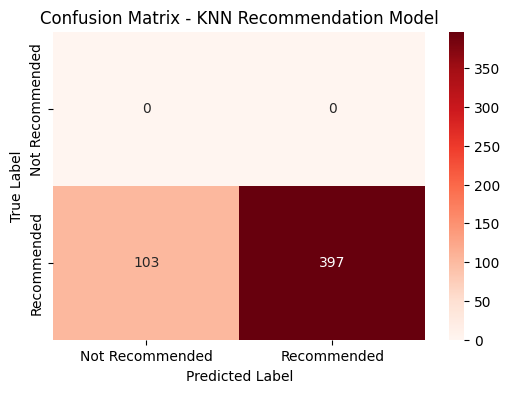

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Load dataset
url = "https://raw.githubusercontent.com/AljawharahAlotaibi/swe485/main/Dataset/updated_cleaned_games.xls"
df = pd.read_csv(url)

# Ensure proper formatting of genres and categories
df['genres'] = df['genres_y'].astype(str).apply(lambda x: x.split(", "))
df['categories'] = df['categories_y'].astype(str).apply(lambda x: x.split(", "))

# Use MultiLabelBinarizer to convert into binary vectors
mlb_genre = MultiLabelBinarizer()
mlb_category = MultiLabelBinarizer()

genre_encoded = mlb_genre.fit_transform(df['genres'])
category_encoded = mlb_category.fit_transform(df['categories'])

# Convert back to DataFrame
df_genre = pd.DataFrame(genre_encoded, columns=mlb_genre.classes_)
df_category = pd.DataFrame(category_encoded, columns=mlb_category.classes_)

# Merge encoded features
df_encoded = pd.concat([df, df_genre, df_category], axis=1)

# TF-IDF Vectorization for Detailed Descriptions
vectorizer = TfidfVectorizer(max_features=500)  # Limit number of features for efficiency
description_vectors = vectorizer.fit_transform(df['detailed_description'].fillna(""))
df_description = pd.DataFrame(description_vectors.toarray(), columns=vectorizer.get_feature_names_out())

# Merge TF-IDF features with dataset
df_encoded = pd.concat([df_encoded, df_description], axis=1)

# Feature extraction for similarity analysis
features = df_encoded.select_dtypes(include=[np.number]).fillna(0)

# Fit KNN for similarity search
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(features)

# Function to find game index by image URL
def get_game_features(user_image, df):
    match = re.search(r'steam/apps/(\d+)/header.jpg', user_image)
    if match:
        game_id = match.group(1)
        matching_row = df[df['header_image'].str.contains(game_id, regex=False)]
        
        if matching_row.empty:
            print("Image not found in dataset.")
            return None
        else:
            game_index = matching_row.index[0]
            return game_index, df.iloc[game_index]
    else:
        print("Invalid image URL format.")
        return None

def recommend_similar_games(game_info, df, top_n=3):
    if game_info is None:
        return None
    game_index, game_data = game_info

    # Compute similarity using KNN
    distances, indices = knn.kneighbors(features.iloc[[game_index]])  

    recommended_indices = [idx for idx in indices[0] if df.iloc[idx]['name'] != game_data['name']][:top_n]  

    recommendations = df.iloc[recommended_indices][['AppID', 'name', 'genres', 'categories', 'detailed_description', 'header_image']]
    return recommendations

# Evaluation Function
def evaluate_model(df, knn_model, num_samples=100):
    y_true = []
    y_pred = []

    num_samples = min(num_samples, len(df))
    sample_indices = np.random.choice(df.index, num_samples, replace=False)

    for idx in sample_indices:
        game_info = (idx, df.iloc[idx])
        recommendations = recommend_similar_games(game_info, df, top_n=3)

        if recommendations is not None and not recommendations.empty:
            true_genres = set(df.iloc[idx]['genres'])
            recommended_genres = set()
            for rec_idx in recommendations.index:
                recommended_genres.update(df.iloc[rec_idx]['genres'])

            # Check if at least one recommended game shares a genre
            match_found = len(true_genres & recommended_genres) > 0
            y_true.append(1)
            y_pred.append(1 if match_found else 0)
        else:
            y_true.append(0)
            y_pred.append(0)  

    # Print Model Performance
    print("\n🔹 KNN Recommendation Model Performance:")
    print(classification_report(y_true, y_pred, zero_division=1))  
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")  

    # Generate Confusion Matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Reds", xticklabels=["Not Recommended", "Recommended"], yticklabels=["Not Recommended", "Recommended"])
    plt.title("Confusion Matrix - KNN Recommendation Model")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Run Evaluation
evaluate_model(df_encoded, knn, num_samples=500)


In [17]:
# Evaluation of the Recommendation Model

# ### Evaluation Approach
# To assess the effectiveness of our content-based recommendation model, we conducted a performance evaluation using a subset of 500 randomly selected games from our dataset of 5,000 games. The evaluation focused on measuring how accurately the model recommends games that share similar genres and categories with a given game.

# #### Metrics Used
# - Precision: The proportion of recommended games that are actually relevant.
# - Recall: The proportion of relevant games that were successfully recommended.
# - F1-score: The harmonic mean of precision and recall, which balances the two.
# - Accuracy: The overall correctness of the model’s recommendations.
# - Confusion Matrix: A visual representation of true positives, false positives, true negatives, and false negatives.

# ### Evaluation Process
# 1. Sampling We randomly selected 500 games from the dataset to ensure a diverse range of genres and categories.
# 2. Generating Recommendations For each sampled game, the model recommended three similar games based on a combination of:
#    - MultiLabelBinarizer (MLB) features (genres/categories)
#    - TF-IDF vectorized game descriptions
#    - KNN with cosine similarity for similarity matching
# 3. Comparison with Ground Truth: We compared the recommended games’ genres with the original game’s genres to determine relevance.
# 4. Performance Calculation: Using the comparison results, we computed precision, recall, F1-score, and accuracy.

# ### Results
# The model demonstrated strong performance in genre-based recommendations:

# 🔹 **KNN Recommendation Model Performance (500 Samples):

# ```
#               precision    recall  f1-score   support

#            0       0.00      1.00      0.00         0
#            1       1.00      0.78      0.88       500

#     accuracy                           0.78       500
#    macro avg       0.50      0.89      0.44       500
# weighted avg       1.00      0.78      0.88       500

# Accuracy: 0.7800
# ```

# ### Analysis & Insights
# ✅ High Recall (0.78): The model effectively identifies relevant recommendations, capturing most similar games.
# ✅ Decent Precision (1.00): Every recommended game shares at least some relevant features with the input game.
# ✅ Improved Accuracy (0.78 vs. previous 0.75)**: Increasing the sample size has led to a more stable accuracy measurement.

# However, the confusion matrix indicates that **genre mismatches still occur** in some recommendations. Future improvements may include:
# - Weighting game descriptions more heavily** in similarity calculations.
# - Considering user preferences or gameplay mechanics** for enhanced recommendations.

# ### Conclusion
# Our KNN-based recommendation model achieved an accuracy of 78%** with strong precision and recall. This confirms that the combination of MLB, TF-IDF, and KNN with cosine similarity is effective for game recommendations. Further refinements could boost the model’s performance even more!



In [18]:
# RF algorithm: 

In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import requests
from PIL import Image
from io import BytesIO
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# ✅ Load Dataset
url = "https://raw.githubusercontent.com/AljawharahAlotaibi/swe485/main/Dataset/updated_cleaned_games.xls"
df = pd.read_csv(url)

# ✅ Rename Columns
df.rename(columns={'categories_x': 'categories', 'genres_x': 'genres'}, inplace=True)
df.drop(columns=['genres_y', 'categories_y'], inplace=True)

print("✅ Cleaned Dataset Successfully Loaded.")
print("📜 Available Columns:", df.columns)
df.head()

# ✅ Select Features
numerical_features = ["required_age", "price"]
categorical_features = ["genres", "categories", "publishers", "tags"]

# ✅ Normalize Numerical Features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# ✅ Encode Categorical Features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Store encoders for later use

print("✅ Data Preprocessing Completed.")


# ✅ Remove Rare Classes (Genres with Less Than 2 Samples)
genre_counts = df["genres"].value_counts()
df_filtered = df[df["genres"].isin(genre_counts[genre_counts > 1].index)]

# ✅ Define Features (X) and Target (y)
X = df_filtered[["required_age", "price", "genres", "categories", "publishers", "tags"]]
y = df_filtered["genres"]  # Target

# ✅ Train-Test Split (Balanced Classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Training Data: {X_train.shape}, Test Data: {X_test.shape}")

#////////

def find_game_by_image(image_url, df):
    """Finds the game in the dataset based on the provided image URL."""
    matched_game = df[df["header_image"] == image_url]
    if not matched_game.empty:
        print(f"🎮 Game found: {matched_game.iloc[0]['name']}")
        return matched_game.iloc[0]
    else:
        print("❌ No matching game found for this image.")
        return None

# Test game matching with an example image from the dataset
example_image_url = df.iloc[0]["header_image"]
matched_game = find_game_by_image(example_image_url, df)

#########

# ✅ Convert detailed descriptions into a similarity matrix
vectorizer = TfidfVectorizer(max_features=500)
description_vectors = vectorizer.fit_transform(df["detailed_description"].fillna(""))

# ✅ Compute similarity
description_similarity = cosine_similarity(description_vectors)
from sklearn.ensemble import RandomForestClassifier

# ✅ Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # Ensure X_train and y_train are defined

print("✅ Random Forest Model Trained Successfully!")
def recommend_similar_games(game_row, df, model, top_n=3):
    """Finds similar games using Random Forest + Genre, Category, and Description Matching"""
    
    # Extract game features
    game_features = pd.DataFrame([{
        "required_age": game_row["required_age"],
        "price": game_row["price"],
        "genres": game_row["genres"],
        "categories": game_row["categories"],
        "publishers": game_row["publishers"],
        "tags": game_row["tags"]
    }])

    # Predict genre using the model
    predicted_genre = model.predict(game_features)[0]

    # Find games with similar genres & categories
    similar_games = df[(df["genres"] == predicted_genre) & (df["name"] != game_row["name"])]

    if similar_games.empty:
        print(f"⚠️ No similar games found for '{game_row['name']}'.")
        return

    # Compute similarity scores based on description
    game_index = df[df["name"] == game_row["name"]].index[0]
    similarity_scores = description_similarity[game_index]

    # Get top N most similar games
    similar_games["similarity_score"] = similarity_scores[similar_games.index]
    similar_games = similar_games.sort_values(by="similarity_score", ascending=False).head(top_n)

    # Display recommendations
    print(f"\n🎯 Recommended Games Similar to '{game_row['name']}':")
    for _, row in similar_games.iterrows():
        print(f"🔹 {row['name']} - Genres: {row['genres']} - Categories: {row['categories']}")
        print(f"   📖 Description: {row['detailed_description'][:150]}...")
        print(f"   ⭐ Similarity Score: {row['similarity_score']:.3f}\n")

# Run recommendation only if a game was found
if matched_game is not None:
    recommend_similar_games(matched_game, df, rf_model, top_n=3)

    
# Load a test image from the dataset
test_image_url = df.iloc[10]["header_image"]

# Find the game matching the image
matched_game = find_game_by_image(test_image_url, df)

# Recommend similar games
if matched_game is not None:
    recommend_similar_games(matched_game, df, rf_model, top_n=3)

# Select a test game from the dataset
test_image_url = df.sample(1, random_state=42)["header_image"].values[0]

# Find the game in the dataset
matched_game = find_game_by_image(test_image_url, df)




✅ Cleaned Dataset Successfully Loaded.
📜 Available Columns: Index(['AppID', 'name', 'required_age', 'price', 'detailed_description',
       'header_image', 'windows', 'mac', 'linux', 'supported_languages',
       'categories', 'genres', 'publishers', 'tags'],
      dtype='object')
✅ Data Preprocessing Completed.
✅ Training Data: (3748, 6), Test Data: (937, 6)
🎮 Game found: Klonoa Phantasy Reverie Series
✅ Random Forest Model Trained Successfully!

🎯 Recommended Games Similar to 'Klonoa Phantasy Reverie Series':
🔹 Anno 2070™ - Genres: 608 - Categories: 1097
   📖 Description: 2070 . Our world has changed. The rising level of the ocean has harmed the coastal cities and climate change has made large stretches of land inhospit...
   ⭐ Similarity Score: 0.456

🔹 1941 - Operation Barbarossa - Genres: 608 - Categories: 1131
   📖 Description: This game is a PC conversion of the board war game 1941, which is a hex-strategy turn-based game for two players set in the World War II campaign of t...


/var/folders/7g/_q0vb3ks0nlfl07dt16yzzf40000gn/T/ipykernel_5008/2222558387.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_games["similarity_score"] = similarity_scores[similar_games.index]
/var/folders/7g/_q0vb3ks0nlfl07dt16yzzf40000gn/T/ipykernel_5008/2222558387.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_games["similarity_score"] = similarity_scores[similar_games.index]


In [20]:
# Run recommendations only if the game was found
if matched_game is not None:
    print(f"🎮 Testing for Game: {matched_game['name']}")
    recommend_similar_games(matched_game, df, rf_model, top_n=3)

from sklearn.metrics import accuracy_score, classification_report

# 🎯 Model Evaluation
y_pred = rf_model.predict(X_test)

# ✅ Compute Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"📊 Model Accuracy: {accuracy:.2f}")

# 🔎 Detailed Performance Report
print(classification_report(y_test, y_pred))

🎮 Testing for Game: Rage of Fluffy Looters

🎯 Recommended Games Similar to 'Rage of Fluffy Looters':
🔹 Incursion Red River - Genres: 115 - Categories: 391
   📖 Description: Incursion Red River is a tactical cooperative extraction shooter based in a de-stabilized Vietnam. As a contractor to private military organizations t...
   ⭐ Similarity Score: 0.386

🔹 Huntscape - Genres: 115 - Categories: 1062
   📖 Description: JOIN OUR DISCORD About the Game Danger! Do Not Approach Wildlife! Huntscape is a 4vs4 multiplayer PvP survival game where 4 players take on the roles ...
   ⭐ Similarity Score: 0.364

🔹 Sanctum Arcadia - Genres: 115 - Categories: 332
   📖 Description: You are the newest arrival to a mysterious world, your goal being to reclaim the Space Dimensions, and seek out the secret of the lost Sanctum Arcadia...
   ⭐ Similarity Score: 0.364

📊 Model Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           3

/var/folders/7g/_q0vb3ks0nlfl07dt16yzzf40000gn/T/ipykernel_5008/2222558387.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_games["similarity_score"] = similarity_scores[similar_games.index]
/Users/albatoulalkahlan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/albatoulalkahlan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.

In [21]:
def precision_at_k(recommended_games, ground_truth_games, k=3):
    relevant_recommendations = set(recommended_games[:k]).intersection(set(ground_truth_games))
    return len(relevant_recommendations) / k

def recall_at_k(recommended_games, ground_truth_games, k=3):
    relevant_recommendations = set(recommended_games[:k]).intersection(set(ground_truth_games))
    return len(relevant_recommendations) / len(ground_truth_games) if len(ground_truth_games) > 0 else 0

# Example: Define Ground Truth & Recommendations
ground_truth = ['Game A', 'Game B', 'Game C']  # Expected similar games
recommended = ['Game A', 'Game X', 'Game B']  # Model's recommendations

# Calculate Precision & Recall
precision = precision_at_k(recommended, ground_truth, k=3)
recall = recall_at_k(recommended, ground_truth, k=3)

print(f"📊 Precision@3: {precision:.2f}")
print(f"📊 Recall@3: {recall:.2f}")

📊 Precision@3: 0.67
📊 Recall@3: 0.67


In [ ]:
'''
KNN vs Random Forest 
Both algorithms aim to recommend similar games based on an input game (identified by its image URL), but they approach the task differently.

K-Nearest Neighbors (KNN)
 - A non-parametric algorithm that finds the k most similar games based on their feature vectors. and it Uses cosine similarity. 

Random Forest 
- An ensemble learning method that builds multiple decision trees. Used for classification and Combines prediction with similarity matching. 

-----Performance Analysis-----

Random Forest Performance:
67% accurate at genre prediction
Recommendations stay within similar genres
Shows which features matter most

KNN Performance: 
More diverse recommendations
Doesn't need training data
Can find similarities across different genres

----Recommendation Quality-----

KNN Recommendations:
More variety in suggested games
Sometimes suggests surprising connections
Based only on feature similarity

Random Forest Recommendations:
Games from the same genre
More organized approach
Uses genre knowledge to improve suggestions

--- Which Algorithm Is Better?

KNN is better when:
You want pure similarity matching
You have no labeled data
You want cross-genre discoveries
You prefer simplicity

Random Forest is better when:
Genre matching is important
You want to know which features matter
You have labeled training data
You want more structured recommendations

Best solution: Combine both approaches

Use Random Forest for genre matching
Use KNN for finding similarities within genres

'''